In [1]:
!pip install statsforecast -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.6/354.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.1 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# StatsForecast
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

In [3]:
CONFIG = {
    'data_path': '/kaggle/input/day-ahead-electricity-price-data/Day-Ahead_Electricity_Price_Data/Australia/',
    'years': range(2020, 2026),
    'target_zone': 'SA1',
    'resample_freq': '1H',
    'test_year': 2025,
    'season_length': 24,  #24 jam utk daily seasonality
}

print("Konfigurasi:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

Konfigurasi:
   data_path: /kaggle/input/day-ahead-electricity-price-data/Day-Ahead_Electricity_Price_Data/Australia/
   years: range(2020, 2026)
   target_zone: SA1
   resample_freq: 1H
   test_year: 2025
   season_length: 24


In [6]:
def load_aemo_data(config):
    """Load dan merge data AEMO."""
    
    dataframes = []
    
    for year in config['years']:
        filepath = f"{config['data_path']}Australia_AEMO_{year}.csv"
        
        try:
            df = pd.read_csv(filepath)
            
            # Set kolom pertama sebagai datetime
            df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
            df.set_index(df.columns[0], inplace=True)
            
            if config['target_zone'] in df.columns:
                df_zone = df[[config['target_zone']]].copy()
                df_zone.columns = ['y']  # StatsForecast butuh kolom 'y'
                dataframes.append(df_zone)
                print(f"Load {year}: {len(df_zone)} records")
            else:
                print(f"Warning {year}: Kolom {config['target_zone']} tidak ada")
                
        except FileNotFoundError:
            print(f"Error {year}: File tidak ditemukan")
        except Exception as e:
            print(f"Error {year}: {str(e)}")
    
    if dataframes:
        full_data = pd.concat(dataframes, axis=0)
        full_data.sort_index(inplace=True)
        print(f"\nTotal: {len(full_data):,} records")
        return full_data
    else:
        raise ValueError("Tidak ada data yang dimuat")

df_raw = load_aemo_data(CONFIG)

Load 2020: 17568 records
Load 2021: 39600 records
Load 2022: 105120 records
Load 2023: 105120 records
Load 2024: 105408 records
Load 2025: 43489 records

Total: 416,305 records


In [7]:
print("RINGKASAN DATA")
print("-"*70)

print(f"\n1. Shape: {df_raw.shape[0]:,} baris x {df_raw.shape[1]} kolom")

print(f"\n2. Periode:")
print(f"   Mulai: {df_raw.index.min()}")
print(f"   Akhir: {df_raw.index.max()}")
print(f"   Durasi: {(df_raw.index.max() - df_raw.index.min()).days} hari")

print(f"\n3. Frekuensi:")
time_diffs = df_raw.index.to_series().diff().value_counts().head(3)
for freq, count in time_diffs.items():
    print(f"   {freq}: {count:,}")

print(f"\n4. Missing: {df_raw.isnull().sum()[0]:,} ({df_raw.isnull().sum()[0]/len(df_raw)*100:.2f}%)")

print(f"\n5. Statistik:")
print(df_raw['y'].describe())

RINGKASAN DATA
----------------------------------------------------------------------

1. Shape: 416,305 baris x 1 kolom

2. Periode:
   Mulai: 2020-01-01 00:00:00
   Akhir: 2025-06-01 00:00:00
   Durasi: 1978 hari

3. Frekuensi:
   0 days 00:05:00: 385,632
   0 days 00:30:00: 30,672

4. Missing: 0 (0.00%)

5. Statistik:
count    416305.00
mean         98.83
std         448.70
min       -1000.00
25%           3.16
50%          65.30
75%         138.00
max       17500.00
Name: y, dtype: float64


In [8]:
df_hourly = df_raw.resample(CONFIG['resample_freq']).mean()

print("Resampling:")
print(f"   Sebelum: {len(df_raw):,}")
print(f"   Sesudah: {len(df_hourly):,}")
print(f"   Reduksi: {(1 - len(df_hourly)/len(df_raw))*100:.1f}%")

Resampling:
   Sebelum: 416,305
   Sesudah: 47,473
   Reduksi: 88.6%


In [11]:
df_hourly.isnull().sum()

y    0
dtype: int64

In [13]:
# Prepare data
df_sf = df_hourly.reset_index()
df_sf.columns = ['ds', 'y']
df_sf['unique_id'] = 'SA1'  # Single series

# Reorder columns
df_sf = df_sf[['unique_id', 'ds', 'y']]

print("Format StatsForecast:")
print(df_sf.head())
print(f"\nTotal: {len(df_sf):,} records")

Format StatsForecast:
  unique_id                  ds      y
0       SA1 2020-01-01 00:00:00  77.14
1       SA1 2020-01-01 01:00:00  68.55
2       SA1 2020-01-01 02:00:00  68.34
3       SA1 2020-01-01 03:00:00  68.00
4       SA1 2020-01-01 04:00:00  63.16

Total: 47,473 records


Train-Test Split:

Training:
   Periode: 2020-01-01 00:00:00 - 2024-12-31 23:00:00
   Records: 43,848
   Mean: $86.04

Test (2025):
   Periode: 2025-01-01 00:00:00 - 2025-06-01 00:00:00
   Records: 3,625
   Mean: $74.29


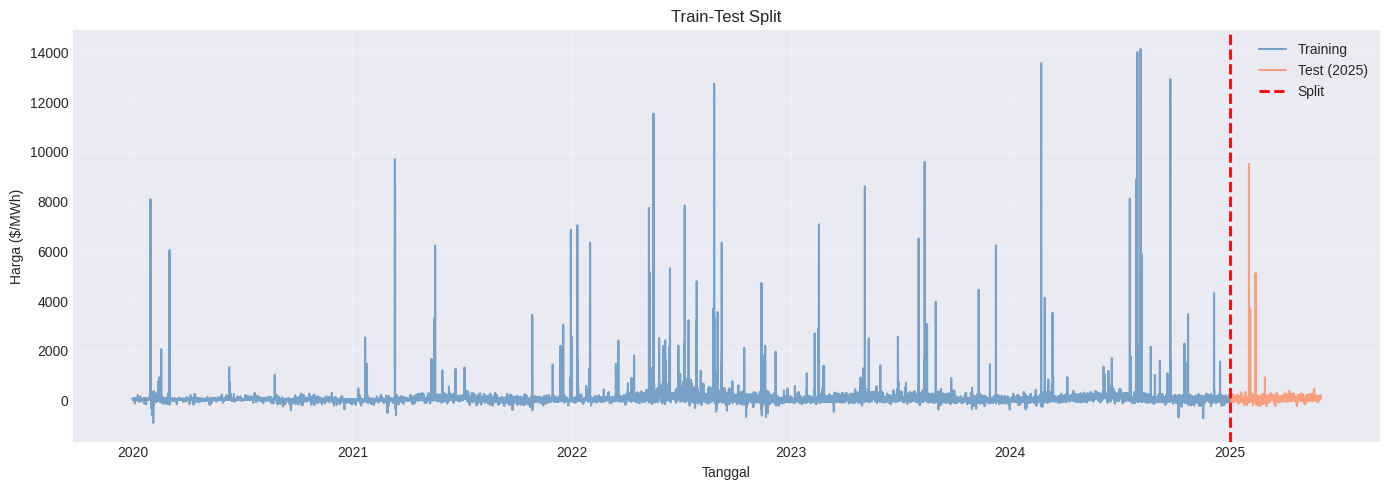

In [14]:
train_df = df_sf[df_sf['ds'].dt.year < CONFIG['test_year']].copy()
test_df = df_sf[df_sf['ds'].dt.year == CONFIG['test_year']].copy()

print("Train-Test Split:")
print(f"\nTraining:")
print(f"   Periode: {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"   Records: {len(train_df):,}")
print(f"   Mean: ${train_df['y'].mean():.2f}")

print(f"\nTest (2025):")
print(f"   Periode: {test_df['ds'].min()} - {test_df['ds'].max()}")
print(f"   Records: {len(test_df):,}")
print(f"   Mean: ${test_df['y'].mean():.2f}")

# Visualisasi split
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_df['ds'], train_df['y'], label='Training', alpha=0.7, color='steelblue')
ax.plot(test_df['ds'], test_df['y'], label='Test (2025)', alpha=0.7, color='coral')
ax.axvline(x=test_df['ds'].min(), color='red', linestyle='--', linewidth=2, label='Split')
ax.set_xlabel('Tanggal')
ax.set_ylabel('Harga ($/MWh)')
ax.set_title('Train-Test Split')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
models = [
    Naive(),
    SeasonalNaive(season_length=CONFIG['season_length']),
    WindowAverage(window_size=CONFIG['season_length']),
]

sf = StatsForecast(
    models=models,
    freq='H',  # Hourly frequency
    n_jobs=-1  # Use all CPU cores
)

print("Models initialized:")
for model in models:
    print(f"   - {model}")

Models initialized:
   - Naive
   - SeasonalNaive
   - WindowAverage


In [16]:
h = len(test_df)  # Forecast untuk seluruh test period
print(f"Generating forecast untuk {h:,} jam...")

forecasts = sf.forecast(df=train_df, h=h)

print("\nForecast generated:")
print(forecasts.head())
print(f"\nShape: {forecasts.shape}")

Generating forecast untuk 3,625 jam...

Forecast generated:
  unique_id                  ds  Naive  SeasonalNaive  WindowAverage
0       SA1 2025-01-01 00:00:00  124.8         165.55          55.73
1       SA1 2025-01-01 01:00:00  124.8         187.90          55.73
2       SA1 2025-01-01 02:00:00  124.8         170.44          55.73
3       SA1 2025-01-01 03:00:00  124.8         185.14          55.73
4       SA1 2025-01-01 04:00:00  124.8         257.30          55.73

Shape: (3625, 5)


In [17]:
# Reset index untuk merge
forecasts_reset = forecasts.reset_index()

# Get actual values
actual_values = test_df['y'].values

# Get predictions
naive_pred = forecasts_reset['Naive'].values
seasonal_naive_pred = forecasts_reset['SeasonalNaive'].values
window_avg_pred = forecasts_reset['WindowAverage'].values

print("Predictions extracted:")
print(f"   Actual: {len(actual_values):,}")
print(f"   Naive: {len(naive_pred):,}")
print(f"   Seasonal Naive: {len(seasonal_naive_pred):,}")
print(f"   Window Average: {len(window_avg_pred):,}")

Predictions extracted:
   Actual: 3,625
   Naive: 3,625
   Seasonal Naive: 3,625
   Window Average: 3,625


In [19]:
def evaluate_forecast(actual, predicted, model_name):
    """Hitung metrik evaluasi."""
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{'-'*60}")
    print(f"{model_name}")
    print(f"{'-'*60}")
    print(f"   MAE:  ${mae:.2f}/MWh")
    print(f"   RMSE: ${rmse:.2f}/MWh")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   RMSE/MAE: {rmse/mae:.2f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

results = {}
results['Naive'] = evaluate_forecast(actual_values, naive_pred, "Naive")
results['Seasonal Naive'] = evaluate_forecast(actual_values, seasonal_naive_pred, "Seasonal Naive")
results['Window Average'] = evaluate_forecast(actual_values, window_avg_pred, "Window Average")


------------------------------------------------------------
Naive
------------------------------------------------------------
   MAE:  $86.89/MWh
   RMSE: $219.41/MWh
   MAPE: 628.61%
   RMSE/MAE: 2.53

------------------------------------------------------------
Seasonal Naive
------------------------------------------------------------
   MAE:  $84.48/MWh
   RMSE: $220.16/MWh
   MAPE: 342.55%
   RMSE/MAE: 2.61

------------------------------------------------------------
Window Average
------------------------------------------------------------
   MAE:  $78.08/MWh
   RMSE: $214.32/MWh
   MAPE: 305.61%
   RMSE/MAE: 2.74


In [22]:
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('MAE')

print("\n" + "-"*70)
print("PERBANDINGAN MODEL")
print("-"*70)
print(comparison_df.to_string())


----------------------------------------------------------------------
PERBANDINGAN MODEL
----------------------------------------------------------------------
                  MAE    RMSE    MAPE
Window Average  78.08  214.32  305.61
Seasonal Naive  84.48  220.16  342.55
Naive           86.89  219.41  628.61


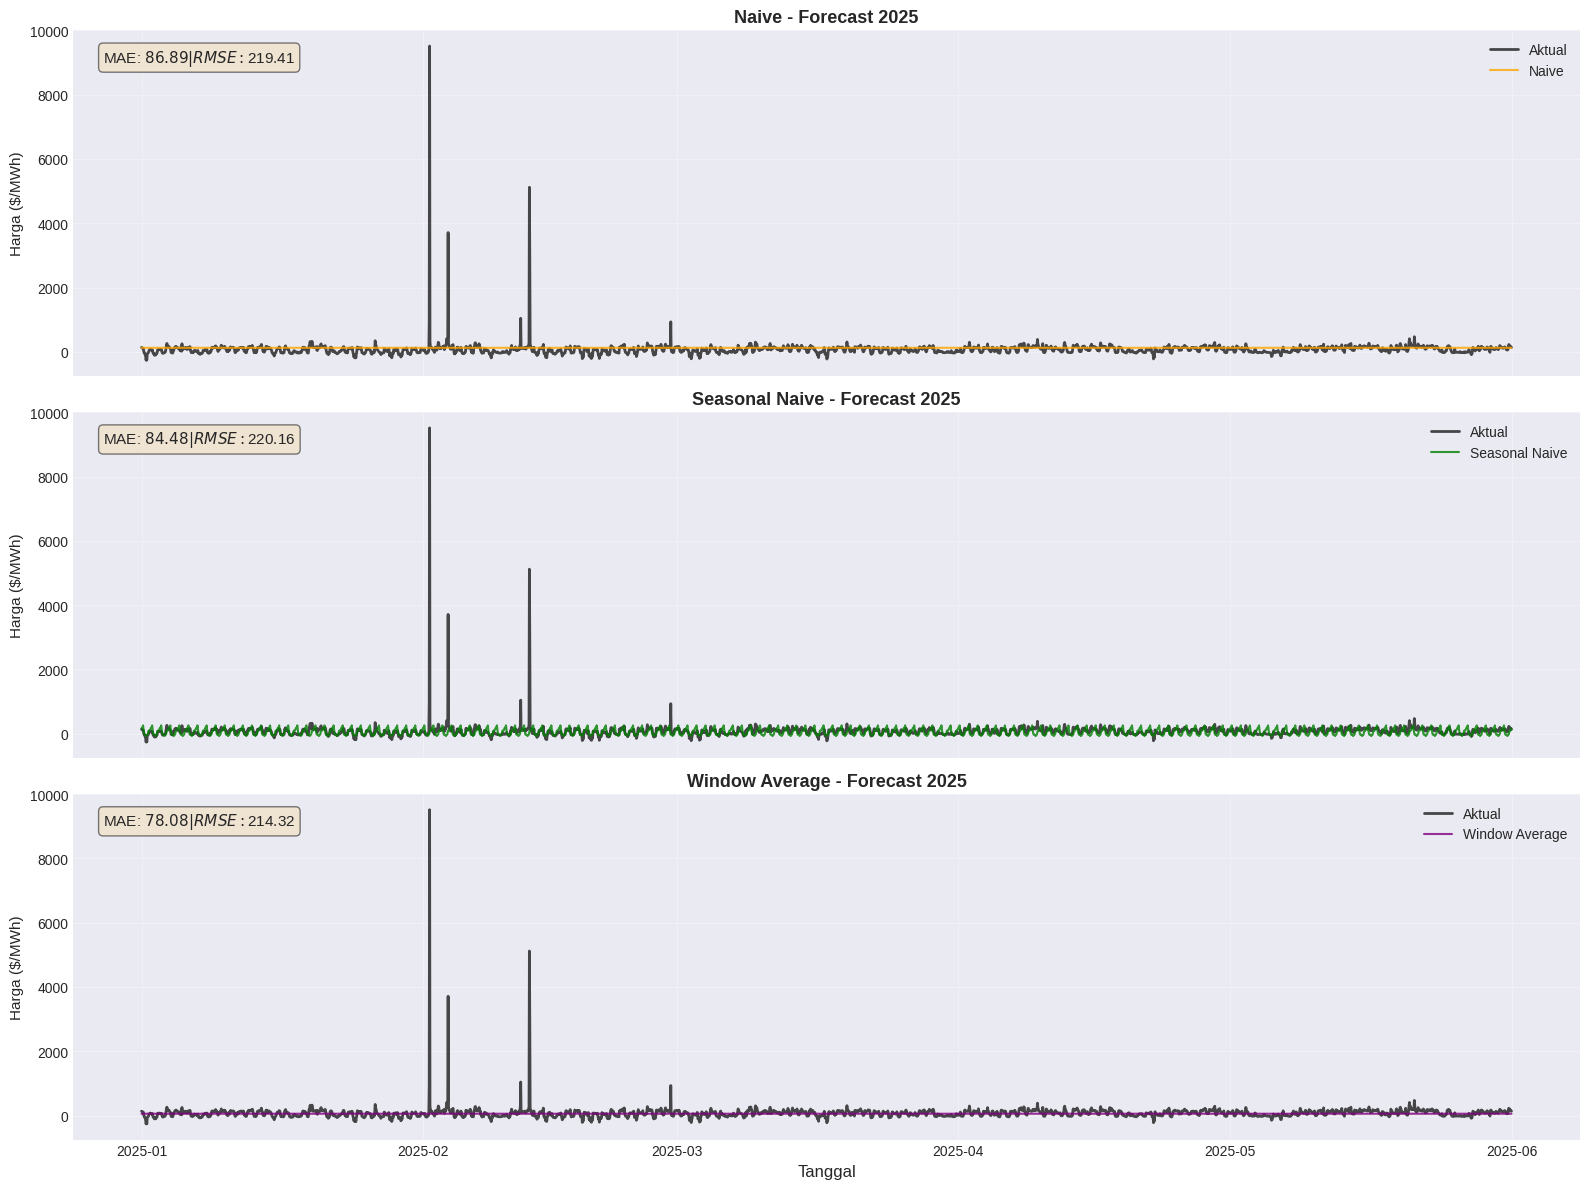

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

models_viz = [
    ('Naive', naive_pred, 'orange'),
    ('Seasonal Naive', seasonal_naive_pred, 'green'),
    ('Window Average', window_avg_pred, 'purple')
]

for idx, (name, predictions, color) in enumerate(models_viz):
    ax = axes[idx]
    
    ax.plot(test_df['ds'], actual_values, label='Aktual', 
            color='black', linewidth=2, alpha=0.7)
    ax.plot(test_df['ds'], predictions, label=f'{name}', 
            color=color, linewidth=1.5, alpha=0.8)
    
    mae = results[name]['MAE']
    rmse = results[name]['RMSE']
    ax.text(0.02, 0.95, f'MAE: ${mae:.2f} | RMSE: ${rmse:.2f}', 
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_ylabel('Harga ($/MWh)', fontsize=11)
    ax.set_title(f'{name} - Forecast 2025', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Tanggal', fontsize=12)
plt.tight_layout()
plt.show()

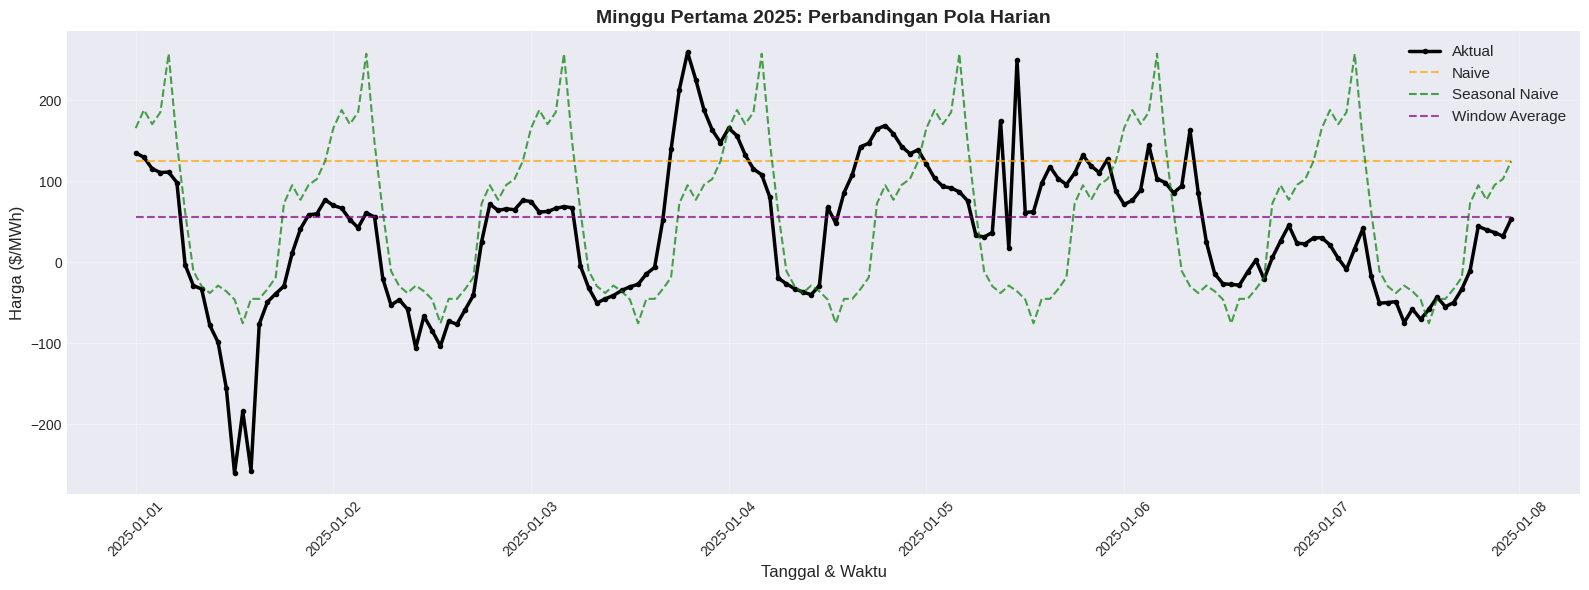

In [24]:
# Cell 15: Zoom Minggu Pertama

first_week_idx = test_df.index[:24*7]
first_week_actual = actual_values[:24*7]

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(test_df.loc[first_week_idx, 'ds'], first_week_actual, 
        label='Aktual', color='black', linewidth=2.5, marker='o', markersize=3)
ax.plot(test_df.loc[first_week_idx, 'ds'], naive_pred[:24*7], 
        label='Naive', color='orange', linewidth=1.5, linestyle='--', alpha=0.7)
ax.plot(test_df.loc[first_week_idx, 'ds'], seasonal_naive_pred[:24*7], 
        label='Seasonal Naive', color='green', linewidth=1.5, linestyle='--', alpha=0.7)
ax.plot(test_df.loc[first_week_idx, 'ds'], window_avg_pred[:24*7], 
        label='Window Average', color='purple', linewidth=1.5, linestyle='--', alpha=0.7)

ax.set_xlabel('Tanggal & Waktu', fontsize=12)
ax.set_ylabel('Harga ($/MWh)', fontsize=12)
ax.set_title('Minggu Pertama 2025: Perbandingan Pola Harian', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

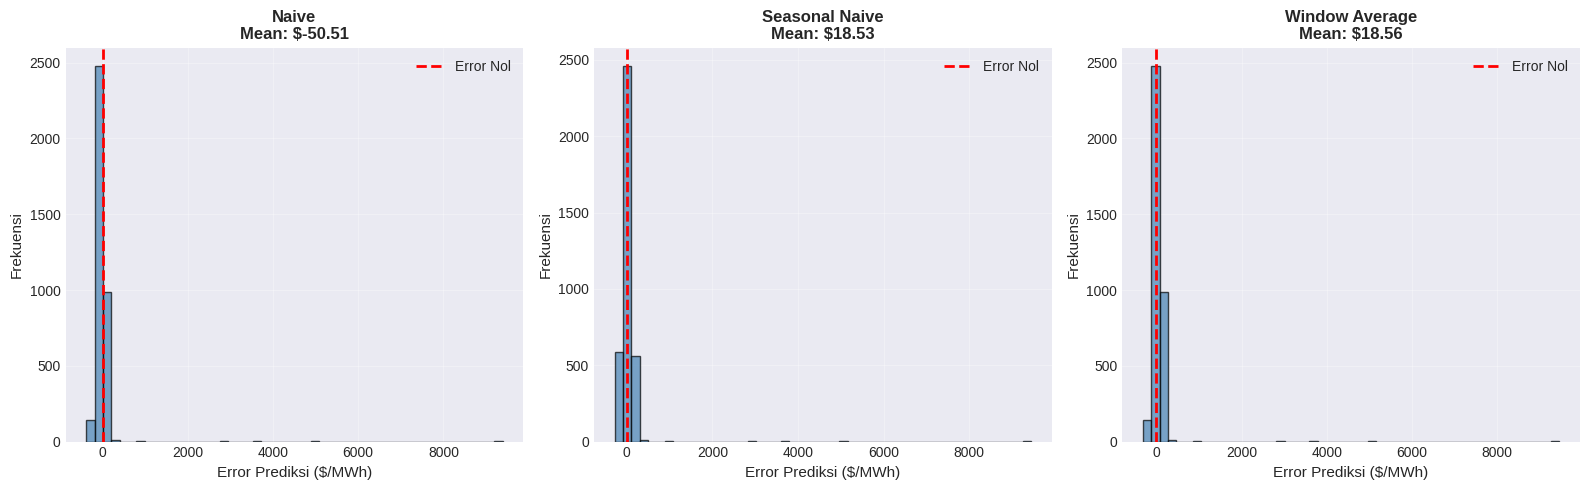

In [25]:
# Cell 16: Error Distribution

errors = {
    'Naive': actual_values - naive_pred,
    'Seasonal Naive': actual_values - seasonal_naive_pred,
    'Window Average': actual_values - window_avg_pred
}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, error) in enumerate(errors.items()):
    ax = axes[idx]
    
    ax.hist(error, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error Nol')
    ax.set_xlabel('Error Prediksi ($/MWh)', fontsize=11)
    ax.set_ylabel('Frekuensi', fontsize=11)
    ax.set_title(f'{name}\nMean: ${np.mean(error):.2f}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
from statsforecast.models import AutoARIMA

In [27]:
#penjelasan ARIMA/SARIMA

"""
ARIMA(p, d, q):
- p: Order of AutoRegressive (AR) - berapa lag masa lalu dipakai
- d: Order of Differencing (I) - berapa kali differencing untuk stationarity
- q: Order of Moving Average (MA) - berapa lag error dipakai

SARIMA(p, d, q)(P, D, Q, m):
- (p, d, q): Non-seasonal component
- (P, D, Q): Seasonal component
- m: Seasonal period (24 untuk hourly dengan daily pattern)

Contoh SARIMA(1,1,1)(1,1,1,24):
- Pakai 1 lag AR, 1 differencing, 1 lag MA
- Pakai 1 seasonal lag, 1 seasonal diff, 1 seasonal MA
- Seasonal period = 24 jam

AutoARIMA akan otomatis cari kombinasi terbaik!
"""

print("Konsep ARIMA/SARIMA dijelaskan")
print("\nParameter yang akan di-tune oleh AutoARIMA:")
print("   - p, d, q (non-seasonal)")
print("   - P, D, Q (seasonal)")
print("   - m = 24 (hourly dengan daily seasonality)")

Konsep ARIMA/SARIMA dijelaskan

Parameter yang akan di-tune oleh AutoARIMA:
   - p, d, q (non-seasonal)
   - P, D, Q (seasonal)
   - m = 24 (hourly dengan daily seasonality)


In [28]:
"""
ARIMA butuh data stasioner (mean & variance konstan).

Non-stationary jika ada:
- Trend (mean berubah seiring waktu)
- Seasonality (pola berulang)
- Heteroscedasticity (variance berubah)

Solusi: Differencing (parameter d dan D)
"""

from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
result = adfuller(train_df['y'].dropna())

print("Uji Stationarity (Augmented Dickey-Fuller Test):")
print(f"   ADF Statistic: {result[0]:.4f}")
print(f"   p-value: {result[1]:.4f}")
print(f"   Critical Values:")
for key, value in result[4].items():
    print(f"      {key}: {value:.4f}")

if result[1] <= 0.05:
    print("\nData STASIONER (p-value <= 0.05)")
    print("   Tidak perlu differencing (d bisa = 0)")
else:
    print("\nData NON-STASIONER (p-value > 0.05)")
    print("   Butuh differencing (d >= 1)")

Uji Stationarity (Augmented Dickey-Fuller Test):
   ADF Statistic: -19.0672
   p-value: 0.0000
   Critical Values:
      1%: -3.4305
      5%: -2.8616
      10%: -2.5668

Data STASIONER (p-value <= 0.05)
   Tidak perlu differencing (d bisa = 0)


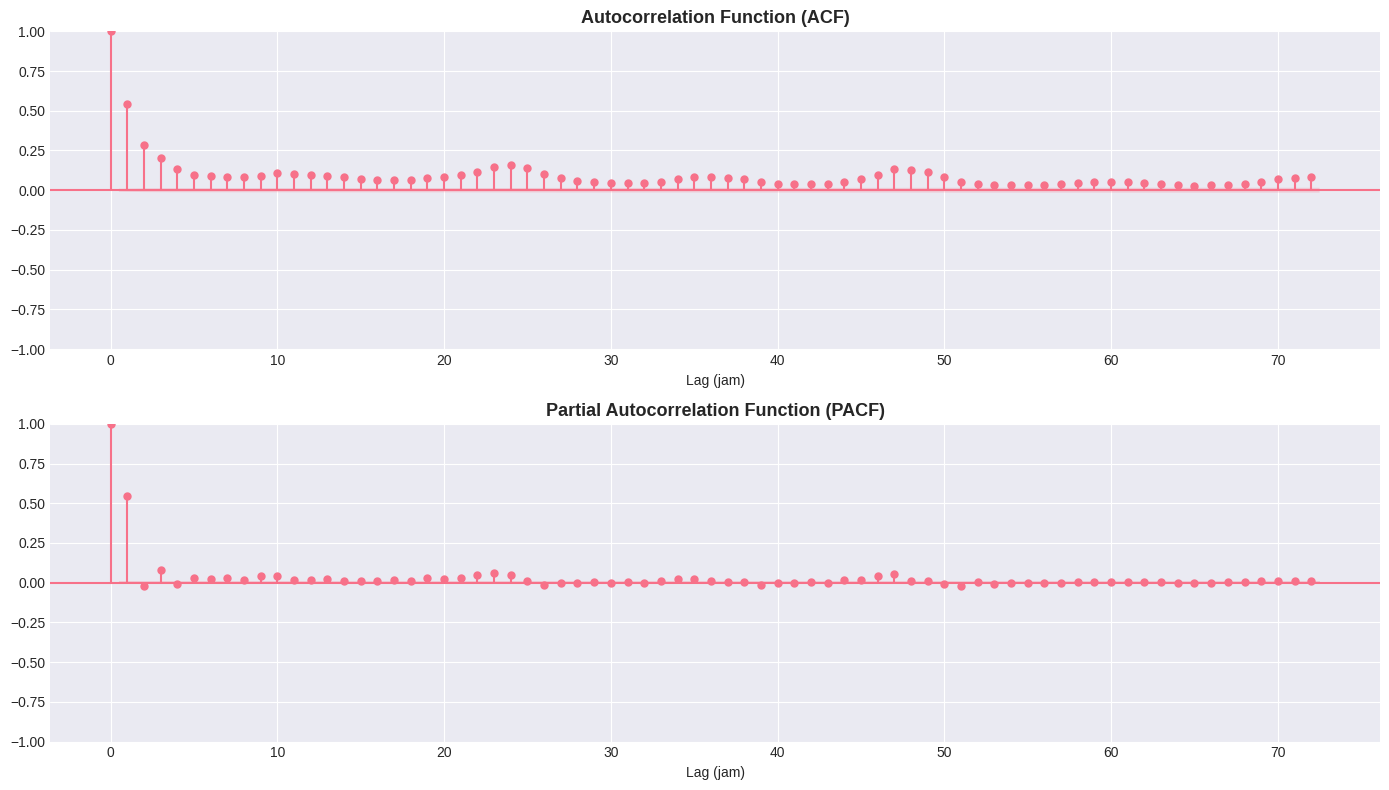

AutoARIMA akan otomatis tune berdasarkan pola diatas


In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(train_df['y'].dropna(), lags=72, ax=axes[0])  # 3 hari
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lag (jam)')

# PACF
plot_pacf(train_df['y'].dropna(), lags=72, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lag (jam)')

plt.tight_layout()
plt.show()

print("AutoARIMA akan otomatis tune berdasarkan pola diatas")

In [33]:
auto_arima_model = AutoARIMA(
    season_length=24,  # Daily seasonality
    approximation=False,  # Exact MLE
    max_p=3,  # Max AR order
    max_q=3,  # Max MA order
    max_P=2,  # Max seasonal AR
    max_Q=2,  # Max seasonal MA
    max_d=2,  # Max differencing
    max_D=1,  # Max seasonal differencing
)

In [34]:
#fit autoarima
import time
# OPTIONAL: Subsample untuk testing cepat (uncomment jika mau cepat)
# train_sample = train_df.iloc[-24*30:]  # Ambil 30 hari terakhir saja
# print(f"Mode: SUBSAMPLE (30 hari terakhir = {len(train_sample)} records)")
# sf_arima = StatsForecast(models=[auto_arima_model], freq='H', n_jobs=1)
# start_time = time.time()
# forecasts_arima = sf_arima.forecast(df=train_sample, h=len(test_df))

# FULL DATA (uncomment untuk hasil final)
sf_arima = StatsForecast(models=[auto_arima_model], freq='H', n_jobs=1)
start_time = time.time()
forecasts_arima = sf_arima.forecast(df=train_df, h=len(test_df))

elapsed = time.time() - start_time
print(f"\n Fitting selesai dalam {elapsed/60:.1f} menit")
print("\nForecast generated:")
print(forecasts_arima.head())


 Fitting selesai dalam 39.6 menit

Forecast generated:
  unique_id                  ds  AutoARIMA
0       SA1 2025-01-01 00:00:00      79.53
1       SA1 2025-01-01 01:00:00      54.96
2       SA1 2025-01-01 02:00:00      45.64
3       SA1 2025-01-01 03:00:00      46.13
4       SA1 2025-01-01 04:00:00      49.88


In [36]:
# Cell 23: Extract Predictions & Evaluate

arima_pred = forecasts_arima.reset_index()['AutoARIMA'].values

print(f"AutoARIMA predictions: {len(arima_pred):,}")

# Evaluate
results['AutoARIMA'] = evaluate_forecast(actual_values, arima_pred, "AutoARIMA")

# Update comparison
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('MAE')

print("\n" + "="*70)
print("UPDATED COMPARISON")
print("-"*70)
print(comparison_df.to_string())

best_model = comparison_df.index[0]
print(f"\n Model Terbaik: {best_model}")
print(f"   MAE: ${comparison_df.iloc[0]['MAE']:.2f}")

AutoARIMA predictions: 3,625

------------------------------------------------------------
AutoARIMA
------------------------------------------------------------
   MAE:  $81.46/MWh
   RMSE: $216.70/MWh
   MAPE: 226.96%
   RMSE/MAE: 2.66

UPDATED COMPARISON
----------------------------------------------------------------------
                  MAE    RMSE    MAPE
Window Average  78.08  214.32  305.61
AutoARIMA       81.46  216.70  226.96
Seasonal Naive  84.48  220.16  342.55
Naive           86.89  219.41  628.61

 Model Terbaik: Window Average
   MAE: $78.08


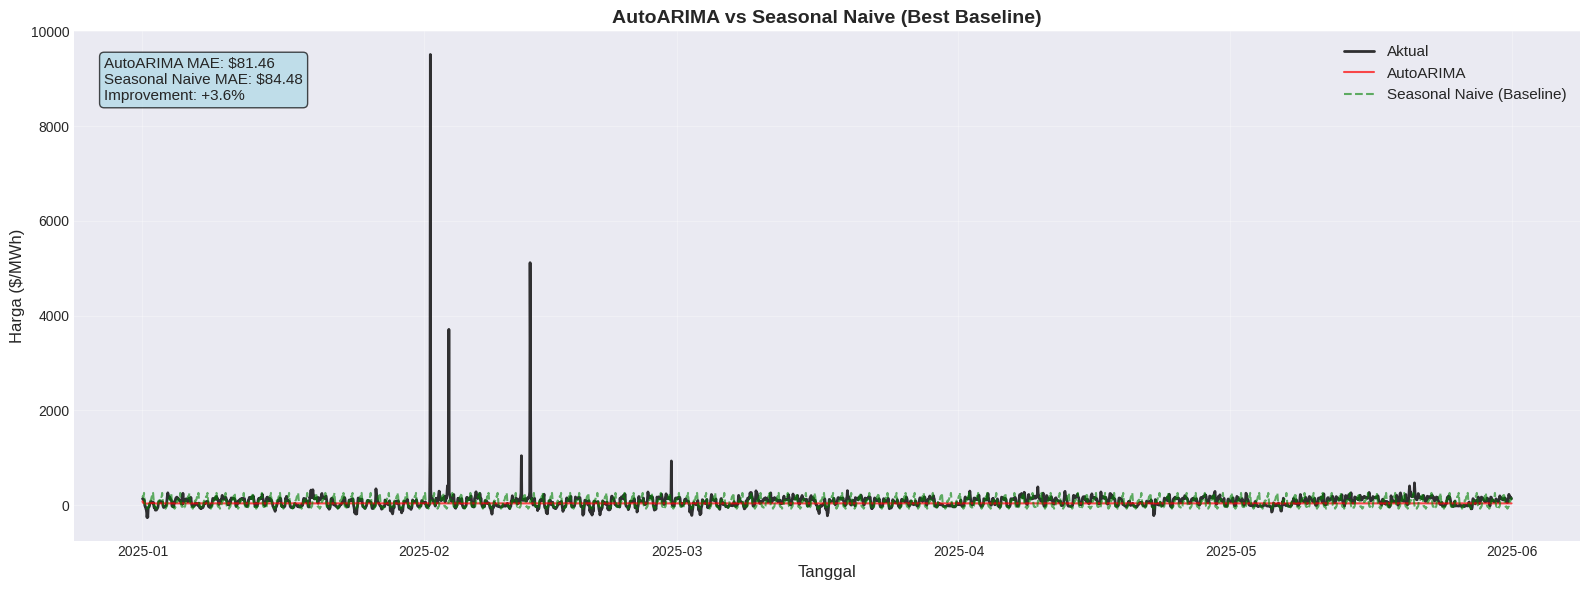

In [37]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(test_df['ds'], actual_values, label='Aktual', 
        color='black', linewidth=2, alpha=0.8)
ax.plot(test_df['ds'], arima_pred, label='AutoARIMA', 
        color='red', linewidth=1.5, alpha=0.7)
ax.plot(test_df['ds'], seasonal_naive_pred, label='Seasonal Naive (Baseline)', 
        color='green', linewidth=1.5, linestyle='--', alpha=0.6)

mae_arima = results['AutoARIMA']['MAE']
mae_baseline = results['Seasonal Naive']['MAE']
improvement = (1 - mae_arima/mae_baseline) * 100

ax.text(0.02, 0.95, 
        f'AutoARIMA MAE: ${mae_arima:.2f}\n' +
        f'Seasonal Naive MAE: ${mae_baseline:.2f}\n' +
        f'Improvement: {improvement:+.1f}%',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Harga ($/MWh)', fontsize=12)
ax.set_title('AutoARIMA vs Seasonal Naive (Best Baseline)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

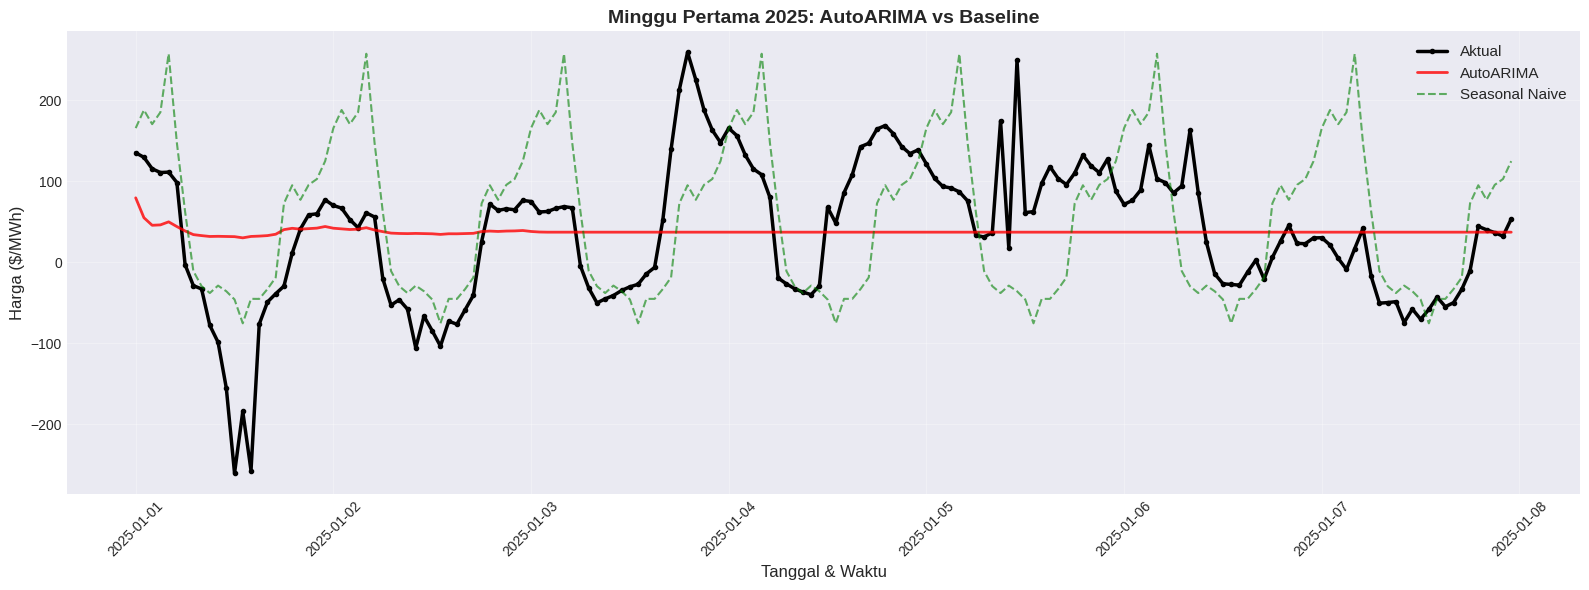

In [38]:
first_week_idx = test_df.index[:24*7]

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(test_df.loc[first_week_idx, 'ds'], actual_values[:24*7], 
        label='Aktual', color='black', linewidth=2.5, marker='o', markersize=3)
ax.plot(test_df.loc[first_week_idx, 'ds'], arima_pred[:24*7], 
        label='AutoARIMA', color='red', linewidth=2, alpha=0.8)
ax.plot(test_df.loc[first_week_idx, 'ds'], seasonal_naive_pred[:24*7], 
        label='Seasonal Naive', color='green', linewidth=1.5, 
        linestyle='--', alpha=0.6)

ax.set_xlabel('Tanggal & Waktu', fontsize=12)
ax.set_ylabel('Harga ($/MWh)', fontsize=12)
ax.set_title('Minggu Pertama 2025: AutoARIMA vs Baseline', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

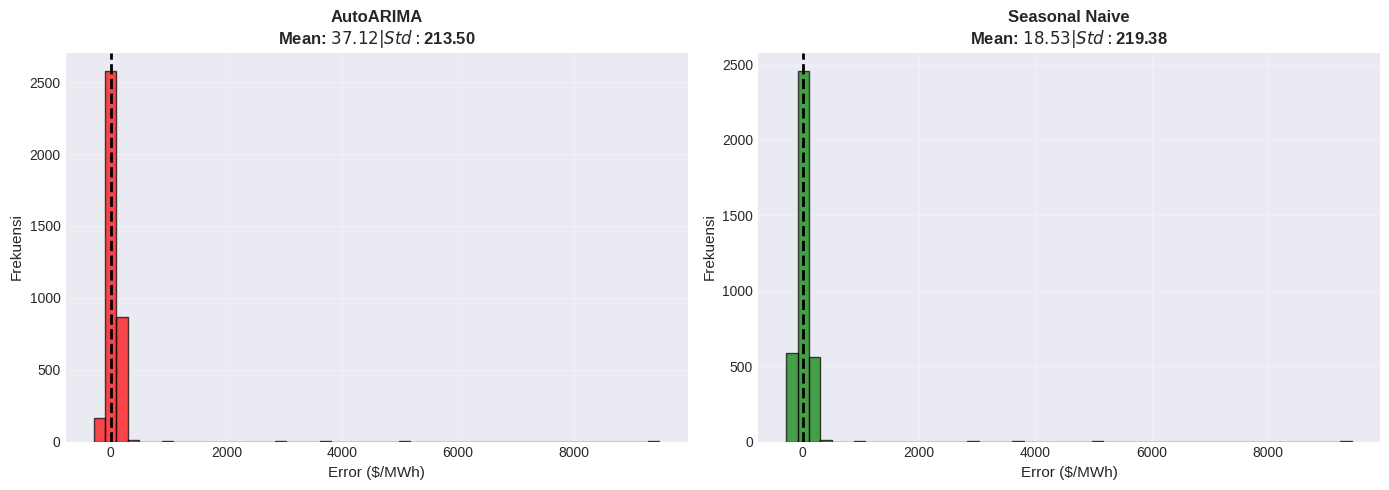

In [39]:
error_arima = actual_values - arima_pred
error_baseline = actual_values - seasonal_naive_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AutoARIMA
axes[0].hist(error_arima, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error ($/MWh)', fontsize=11)
axes[0].set_ylabel('Frekuensi', fontsize=11)
axes[0].set_title(f'AutoARIMA\nMean: ${np.mean(error_arima):.2f} | Std: ${np.std(error_arima):.2f}', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Baseline
axes[1].hist(error_baseline, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Error ($/MWh)', fontsize=11)
axes[1].set_ylabel('Frekuensi', fontsize=11)
axes[1].set_title(f'Seasonal Naive\nMean: ${np.mean(error_baseline):.2f} | Std: ${np.std(error_baseline):.2f}', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

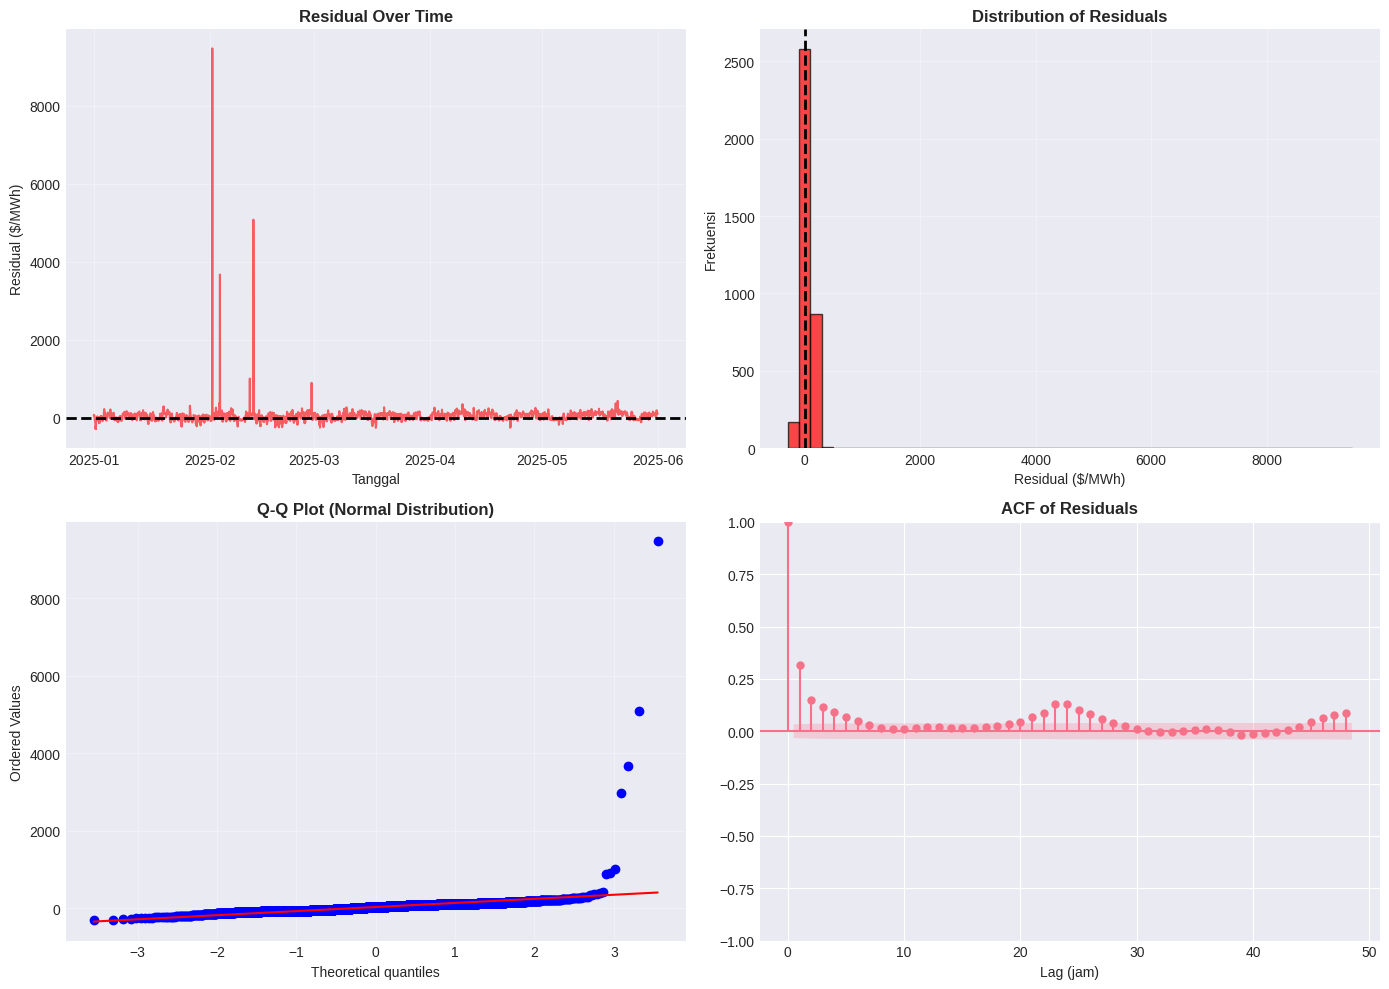


Residual Analysis:
   Mean: $37.12 (idealnya ≈ 0)
   Std Dev: $213.50
   Skewness: 29.61 (idealnya ≈ 0)
   Kurtosis: 1170.38 (idealnya ≈ 0)

   Ljung-Box Test (lag 24):
      p-value: 0.0000
    Autocorrelation detected (model bisa ditingkatkan)


In [40]:
#Residual Diagnostics (Check Model Quality)

"""
Residual yang baik harus:
1. Mean ≈ 0 (unbiased)
2. Constant variance (homoscedastic)
3. No autocorrelation (white noise)
4. Normally distributed

Jika residual tidak white noise → model masih bisa ditingkatkan
"""

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residual over time
axes[0, 0].plot(test_df['ds'], error_arima, color='red', alpha=0.6)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Tanggal')
axes[0, 0].set_ylabel('Residual ($/MWh)')
axes[0, 0].set_title('Residual Over Time', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram
axes[0, 1].hist(error_arima, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residual ($/MWh)')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].set_title('Distribution of Residuals', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot
from scipy import stats
stats.probplot(error_arima, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal Distribution)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF of Residuals
plot_acf(error_arima, lags=48, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals', fontweight='bold')
axes[1, 1].set_xlabel('Lag (jam)')

plt.tight_layout()
plt.show()

print("\nResidual Analysis:")
print(f"   Mean: ${np.mean(error_arima):.2f} (idealnya ≈ 0)")
print(f"   Std Dev: ${np.std(error_arima):.2f}")
print(f"   Skewness: {stats.skew(error_arima):.2f} (idealnya ≈ 0)")
print(f"   Kurtosis: {stats.kurtosis(error_arima):.2f} (idealnya ≈ 0)")

# Ljung-Box test untuk autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(error_arima, lags=[24], return_df=True)
print(f"\n   Ljung-Box Test (lag 24):")
print(f"      p-value: {lb_test['lb_pvalue'].values[0]:.4f}")
if lb_test['lb_pvalue'].values[0] > 0.05:
    print("    No autocorrelation (white noise)")
else:
    print("    Autocorrelation detected (model bisa ditingkatkan)")

In [41]:
"""
XGBoost = eXtreme Gradient Boosting

Perbedaan dengan ARIMA:
- ARIMA: Linear, statistical model
- XGBoost: Non-linear, tree-based ML model

Keunggulan untuk electricity price:
Handle non-linearity (price spikes)
Feature importance (tahu faktor apa yang penting)
Robust terhadap outliers
Tidak butuh stationarity
Bisa pakai external features (weather, time, etc)
"""

!pip install xgboost -q

import xgboost as xgb
from sklearn.preprocessing import StandardScaler

print("XGBoost ready")
print(f"XGBoost version: {xgb.__version__}")

XGBoost ready
XGBoost version: 3.1.0


In [43]:
"""
Cara Kerja XGBoost

1. GRADIENT BOOSTING
   - Bangun pohon decision tree secara iteratif
   - Setiap pohon baru memperbaiki error pohon sebelumnya
   - Final prediction = sum of all trees

   Analogi: Tim yang belajar dari kesalahan
   - Tree 1: Prediksi awal (masih banyak error)
   - Tree 2: Fokus memperbaiki error Tree 1
   - Tree 3: Fokus memperbaiki error Tree 1 + Tree 2
   - ... (iterate 100-1000 trees)

2. DECISION TREE
   - Split data berdasarkan features
   - Contoh splits untuk electricity:
     * "Jika jam >= 18 dan < 22, harga tinggi (peak evening)"
     * "Jika hari = weekend dan jam < 10, harga rendah"
     * "Jika lag_24h > 200, harga tinggi (momentum)"

3. GRADIENT DESCENT
   - Optimasi untuk minimize error (loss function)
   - Setiap tree bergerak ke arah yang reduce loss paling banyak

4. REGULARIZATION
   - Prevent overfitting dengan:
     * max_depth: Batasi kedalaman pohon
     * min_child_weight: Minimum sampel per leaf
     * gamma: Minimum loss reduction untuk split
     * lambda, alpha: L1/L2 regularization

Kenapa "eXtreme"?
- Optimized implementation (parallel processing)
- Smart handling of missing values
- Built-in cross-validation
- Regularization to prevent overfitting
"""

print("\nKunci XGBoost:")
print("   1. Feature Engineering yang baik")
print("   2. Hyperparameter tuning")
print("   3. Handle imbalanced data (spikes vs normal)")


Kunci XGBoost:
   1. Feature Engineering yang baik
   2. Hyperparameter tuning
   3. Handle imbalanced data (spikes vs normal)


In [45]:
# f eng

"""
Time-series features untuk electricity price:
1. LAG FEATURES: Harga di waktu lalu
   - lag_1h: Harga 1 jam lalu
   - lag_24h: Harga 24 jam lalu (daily seasonality)
   - lag_168h: Harga 168 jam lalu (weekly seasonality)

2. ROLLING STATISTICS: Agregasi window
   - rolling_mean_24h: Rata-rata 24 jam terakhir
   - rolling_std_24h: Volatilitas 24 jam terakhir
   - rolling_min/max_24h: Range harga

3. TIME FEATURES: Pola temporal
   - hour: Jam dalam sehari (0-23)
   - day_of_week: Hari dalam minggu (0-6)
   - is_weekend: Boolean weekend/weekday
   - month: Musim/bulan

4. INTERACTION FEATURES:
   - hour × day_of_week: Kombinasi patterns

Prinsip: Transform time-series → supervised learning problem
"""

def create_features(df, is_train=True):
    """
    Create features untuk XGBoost
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data dengan kolom 'ds' (datetime) dan 'y' (target)
    is_train : bool
        True jika training (include target), False jika inference
    """
    
    df = df.copy()
    
    # 1. LAG FEATURES (paling penting untuk time-series!)
    df['lag_1h'] = df['y'].shift(1)
    df['lag_2h'] = df['y'].shift(2)
    df['lag_3h'] = df['y'].shift(3)
    df['lag_6h'] = df['y'].shift(6)
    df['lag_12h'] = df['y'].shift(12)
    df['lag_24h'] = df['y'].shift(24)  # Daily seasonality
    df['lag_48h'] = df['y'].shift(48)
    df['lag_168h'] = df['y'].shift(168)  # Weekly seasonality
    
    # 2. ROLLING STATISTICS
    df['rolling_mean_3h'] = df['y'].shift(1).rolling(window=3).mean()
    df['rolling_mean_6h'] = df['y'].shift(1).rolling(window=6).mean()
    df['rolling_mean_12h'] = df['y'].shift(1).rolling(window=12).mean()
    df['rolling_mean_24h'] = df['y'].shift(1).rolling(window=24).mean()
    
    df['rolling_std_24h'] = df['y'].shift(1).rolling(window=24).std()
    df['rolling_min_24h'] = df['y'].shift(1).rolling(window=24).min()
    df['rolling_max_24h'] = df['y'].shift(1).rolling(window=24).max()
    
    # 3. TIME FEATURES
    df['hour'] = df['ds'].dt.hour
    df['day_of_week'] = df['ds'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_of_month'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['week_of_year'] = df['ds'].dt.isocalendar().week
    
    # 4. BINARY FEATURES
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_peak_morning'] = ((df['hour'] >= 6) & (df['hour'] <= 9)).astype(int)
    df['is_peak_evening'] = ((df['hour'] >= 17) & (df['hour'] <= 21)).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int)
    
    # 5. CYCLICAL ENCODING (untuk hour)
    # Hour itu cyclical: jam 23 dekat dengan jam 0
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Day of week cyclical
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # 6. INTERACTION FEATURES
    df['hour_dow'] = df['hour'] * df['day_of_week']
    
    return df

print("\nFeatures yang akan dibuat:")
print("   - 8 Lag features (1h, 2h, 3h, 6h, 12h, 24h, 48h, 168h)")
print("   - 7 Rolling statistics (mean, std, min, max)")
print("   - 6 Time features (hour, day, month, etc)")
print("   - 4 Binary features (weekend, peak hours)")
print("   - 4 Cyclical encoding (sin/cos)")
print("   - 1 Interaction feature")
print("   Total: ~30 features")


Features yang akan dibuat:
   - 8 Lag features (1h, 2h, 3h, 6h, 12h, 24h, 48h, 168h)
   - 7 Rolling statistics (mean, std, min, max)
   - 6 Time features (hour, day, month, etc)
   - 4 Binary features (weekend, peak hours)
   - 4 Cyclical encoding (sin/cos)
   - 1 Interaction feature
   Total: ~30 features


In [46]:
#apply f eng
train_features = create_features(train_df, is_train=True)

test_features = create_features(test_df, is_train=True)

print(f"\nTraining shape: {train_features.shape}")
print(f"Test shape: {test_features.shape}")

print("\nSample features:")
print(train_features.head())

# Check missing values (dari lag/rolling features)
missing_count = train_features.isnull().sum().sum()
print(f"\nMissing values: {missing_count:,}")
print("(Normal karena lag/rolling features butuh history)")


Training shape: (43848, 33)
Test shape: (3625, 33)

Sample features:
  unique_id                  ds      y  lag_1h  lag_2h  lag_3h  lag_6h  \
0       SA1 2020-01-01 00:00:00  77.14     NaN     NaN     NaN     NaN   
1       SA1 2020-01-01 01:00:00  68.55   77.14     NaN     NaN     NaN   
2       SA1 2020-01-01 02:00:00  68.34   68.55   77.14     NaN     NaN   
3       SA1 2020-01-01 03:00:00  68.00   68.34   68.55   77.14     NaN   
4       SA1 2020-01-01 04:00:00  63.16   68.00   68.34   68.55     NaN   

   lag_12h  lag_24h  lag_48h  lag_168h  rolling_mean_3h  rolling_mean_6h  \
0      NaN      NaN      NaN       NaN              NaN              NaN   
1      NaN      NaN      NaN       NaN              NaN              NaN   
2      NaN      NaN      NaN       NaN              NaN              NaN   
3      NaN      NaN      NaN       NaN            71.34              NaN   
4      NaN      NaN      NaN       NaN            68.29              NaN   

   rolling_mean_12h  rolling

In [47]:
#prepare data utk xgb
"""
XGBoost butuh format:
- X: Matrix features (2D array)
- y: Target vector (1D array)

Kita drop:
- 'ds': Datetime (sudah di-extract jadi hour, day, etc)
- 'y': Target (jadi y terpisah)
- 'unique_id': Identifier

Kita remove rows dengan NaN (dari lag features di awal)
"""

# Define feature columns (exclude target dan metadata)
feature_cols = [col for col in train_features.columns 
                if col not in ['ds', 'y', 'unique_id']]

print(f"Feature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i}. {col}")

# Prepare training data (drop NaN dari lag features)
train_clean = train_features.dropna().copy()
X_train = train_clean[feature_cols]
y_train = train_clean['y']

print(f"\nTraining data:")
print(f"   Original: {len(train_features):,} rows")
print(f"   After dropna: {len(train_clean):,} rows")
print(f"   Dropped: {len(train_features) - len(train_clean):,} rows")

# Prepare test data
test_clean = test_features.dropna().copy()
X_test = test_clean[feature_cols]
y_test = test_clean['y']

print(f"\nTest data:")
print(f"   Original: {len(test_features):,} rows")
print(f"   After dropna: {len(test_clean):,} rows")

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Feature columns (30):
   1. lag_1h
   2. lag_2h
   3. lag_3h
   4. lag_6h
   5. lag_12h
   6. lag_24h
   7. lag_48h
   8. lag_168h
   9. rolling_mean_3h
   10. rolling_mean_6h
   11. rolling_mean_12h
   12. rolling_mean_24h
   13. rolling_std_24h
   14. rolling_min_24h
   15. rolling_max_24h
   16. hour
   17. day_of_week
   18. day_of_month
   19. month
   20. quarter
   21. week_of_year
   22. is_weekend
   23. is_peak_morning
   24. is_peak_evening
   25. is_night
   26. hour_sin
   27. hour_cos
   28. dow_sin
   29. dow_cos
   30. hour_dow

Training data:
   Original: 43,848 rows
   After dropna: 43,680 rows
   Dropped: 168 rows

Test data:
   Original: 3,625 rows
   After dropna: 3,457 rows

X_train shape: (43680, 30)
X_test shape: (3457, 30)


In [53]:
#modelling

"""
hyperparams xgb 
KEY PARAMETERS:

1. n_estimators (100-1000)
   - Jumlah trees
   - Lebih banyak = lebih powerful, tapi bisa overfit

2. max_depth (3-10)
   - Kedalaman pohon
   - Lebih dalam = lebih kompleks, tapi bisa overfit
   - Default 6 biasanya bagus

3. learning_rate (0.01-0.3)
   - Seberapa banyak setiap tree "contribute"
   - Lebih kecil = lebih hati-hati (butuh lebih banyak trees)
   - 0.1 adalah good starting point

4. subsample (0.5-1.0)
   - Fraction of data untuk setiap tree
   - < 1.0 = prevent overfitting

5. colsample_bytree (0.5-1.0)
   - Fraction of features untuk setiap tree
   - Random feature selection = prevent overfitting

6. reg_alpha, reg_lambda
   - L1 dan L2 regularization
   - Prevent overfitting

Strategy: Start conservative, then tune
"""

model_xgb = xgb.XGBRegressor(
    n_estimators=500,        # Jumlah trees
    max_depth=6,             # Kedalaman pohon
    learning_rate=0.1,       # Learning rate
    subsample=0.8,           # 80% data per tree
    colsample_bytree=0.8,    # 80% features per tree
    reg_alpha=0.1,           # L1 regularization
    reg_lambda=1.0,          # L2 regularization
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    tree_method='hist',      # Faster training
    verbosity=1,
    early_stopping_rounds=10
)

print("\nHyperparameters:")
print(f"   n_estimators: {model_xgb.n_estimators}")
print(f"   max_depth: {model_xgb.max_depth}")
print(f"   learning_rate: {model_xgb.learning_rate}")
print(f"   subsample: {model_xgb.subsample}")
print(f"   colsample_bytree: {model_xgb.colsample_bytree}")


Hyperparameters:
   n_estimators: 500
   max_depth: 6
   learning_rate: 0.1
   subsample: 0.8
   colsample_bytree: 0.8


In [55]:
#training
"""
XGBoost training:
1. Build tree 1 → predict
2. Calculate residual (error)
3. Build tree 2 to predict residual
4. Update prediction = tree1 + tree2
5. Repeat untuk n_estimators trees

Early stopping: Stop jika validation error tidak improve
"""

# Train dengan evaluation set
# Note: eval_set harus ada karena early_stopping_rounds sudah diset di model
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=50
)

print(f"   Best iteration: {model_xgb.best_iteration}")
print(f"   Best score: {model_xgb.best_score:.2f}")

[0]	validation_0-rmse:299.33482	validation_1-rmse:213.07030
[21]	validation_0-rmse:163.75628	validation_1-rmse:187.98645
   Best iteration: 12
   Best score: 184.02


In [56]:
# Predict
xgb_pred = model_xgb.predict(X_test)

print(f"Predictions generated: {len(xgb_pred):,}")
print(f"   Min: ${xgb_pred.min():.2f}")
print(f"   Max: ${xgb_pred.max():.2f}")
print(f"   Mean: ${xgb_pred.mean():.2f}")

# Evaluate
results['XGBoost'] = evaluate_forecast(y_test.values, xgb_pred, "XGBoost")

Predictions generated: 3,457
   Min: $-114.16
   Max: $3200.14
   Mean: $80.81

------------------------------------------------------------
XGBoost
------------------------------------------------------------
   MAE:  $39.87/MWh
   RMSE: $184.02/MWh
   MAPE: 210.60%
   RMSE/MAE: 4.62


In [57]:
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('MAE')
print(comparison_df.to_string())

best_model = comparison_df.index[0]
print(f"\n Model Terbaik: {best_model}")
print(f"   MAE: ${comparison_df.iloc[0]['MAE']:.2f}")

# Improvement vs baseline
baseline_mae = results['Seasonal Naive']['MAE']
xgb_mae = results['XGBoost']['MAE']
improvement = (1 - xgb_mae/baseline_mae) * 100

print(f"\n XGBoost vs Seasonal Naive:")
print(f"   Improvement: {improvement:+.1f}%")

# Improvement vs ARIMA
if 'AutoARIMA' in results:
    arima_mae = results['AutoARIMA']['MAE']
    improvement_arima = (1 - xgb_mae/arima_mae) * 100
    print(f"\n XGBoost vs AutoARIMA:")
    print(f"   Improvement: {improvement_arima:+.1f}%")

                  MAE    RMSE    MAPE
XGBoost         39.87  184.02  210.60
Window Average  78.08  214.32  305.61
AutoARIMA       81.46  216.70  226.96
Seasonal Naive  84.48  220.16  342.55
Naive           86.89  219.41  628.61

 Model Terbaik: XGBoost
   MAE: $39.87

 XGBoost vs Seasonal Naive:
   Improvement: +52.8%

 XGBoost vs AutoARIMA:
   Improvement: +51.0%


TOP 20 FEATURE IMPORTANCE
         feature  importance
          lag_1h        0.08
 rolling_mean_3h        0.07
         lag_48h        0.07
rolling_mean_12h        0.07
        hour_dow        0.05
 rolling_min_24h        0.05
 rolling_std_24h        0.05
     day_of_week        0.05
          lag_6h        0.05
    week_of_year        0.04
rolling_mean_24h        0.04
         lag_24h        0.04
        hour_sin        0.04
         dow_sin        0.03
         lag_12h        0.03
      is_weekend        0.03
        lag_168h        0.03
 is_peak_evening        0.03
        hour_cos        0.03
 rolling_max_24h        0.02


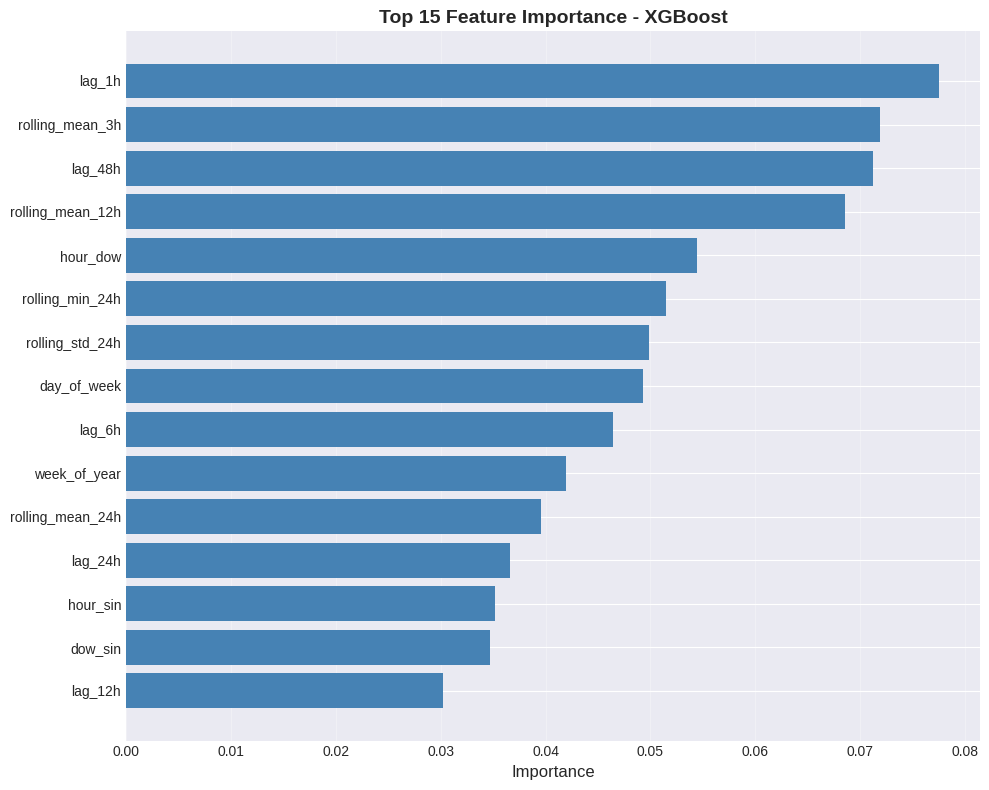


 Insight:
   - Lag features biasanya paling penting (lag_24h, lag_1h)
   - Rolling statistics capture short-term trends
   - Time features (hour, day_of_week) capture seasonality


In [58]:
"""
GBoost memberikan importance score:
- Gain: Total improvement dari splits using this feature
- Weight: Number of times feature used in splits
- Cover: Average coverage (samples affected)

Ini memberi insight: feature apa yang paling penting?
"""

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_xgb.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

print("="*70)
print("TOP 20 FEATURE IMPORTANCE")
print("="*70)
print(importance_df.head(20).to_string(index=False))

# Visualize top 15
fig, ax = plt.subplots(figsize=(10, 8))

top_features = importance_df.head(15)
ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n Insight:")
print("   - Lag features biasanya paling penting (lag_24h, lag_1h)")
print("   - Rolling statistics capture short-term trends")
print("   - Time features (hour, day_of_week) capture seasonality")

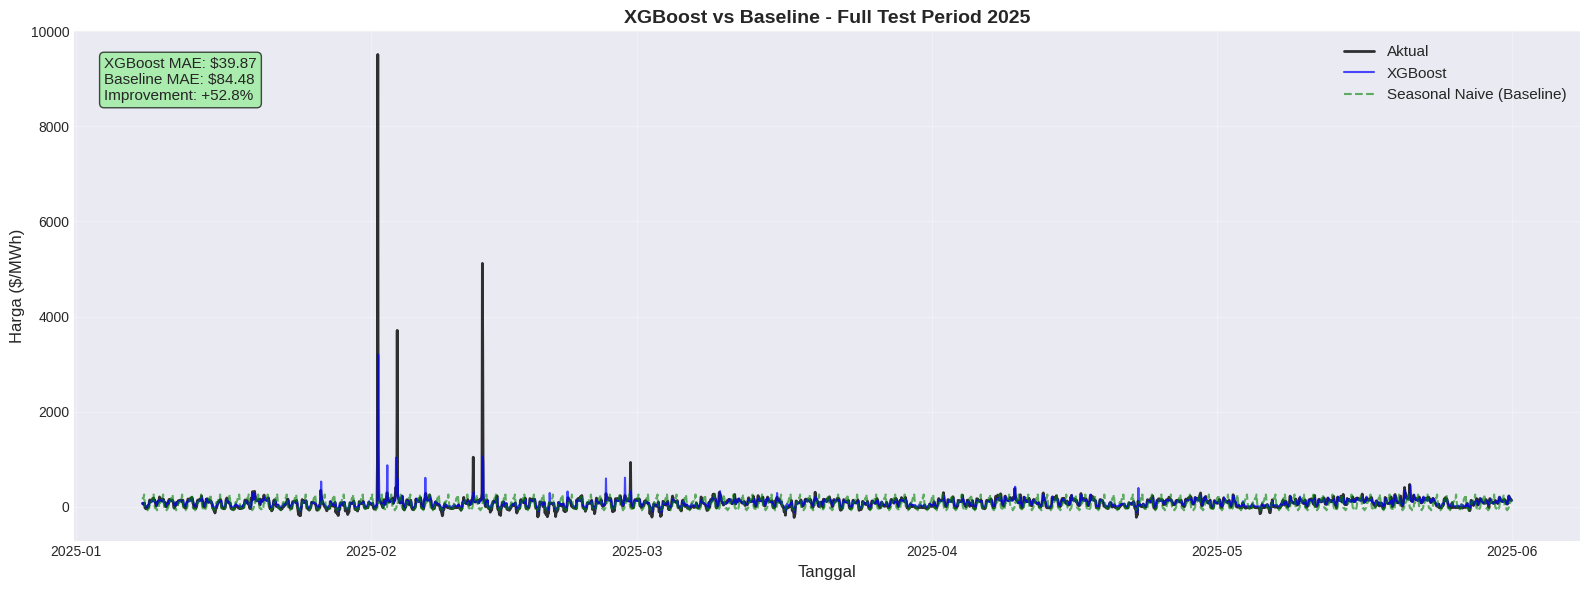

In [60]:
fig, ax = plt.subplots(figsize=(16, 6))

# Align dengan test_clean (karena ada dropna)
test_dates = test_clean['ds'].values

ax.plot(test_dates, y_test.values, label='Aktual', 
        color='black', linewidth=2, alpha=0.8)
ax.plot(test_dates, xgb_pred, label='XGBoost', 
        color='blue', linewidth=1.5, alpha=0.7)

# Tambahkan baseline terbaik untuk perbandingan
# Perlu align dengan test_clean index
baseline_aligned = seasonal_naive_pred[-len(test_clean):]

# Pastikan bentuknya array 1 dimensi (kadang perlu jika tipe datanya beda)
import numpy as np
baseline_aligned = np.array(baseline_aligned).flatten()

# Plotting
ax.plot(test_dates, baseline_aligned, label='Seasonal Naive (Baseline)', 
        color='green', linewidth=1.5, linestyle='--', alpha=0.6)
xgb_mae = results['XGBoost']['MAE']
baseline_mae = results['Seasonal Naive']['MAE']

ax.text(0.02, 0.95, 
        f'XGBoost MAE: ${xgb_mae:.2f}\n' +
        f'Baseline MAE: ${baseline_mae:.2f}\n' +
        f'Improvement: {improvement:+.1f}%',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Harga ($/MWh)', fontsize=12)
ax.set_title('XGBoost vs Baseline - Full Test Period 2025', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

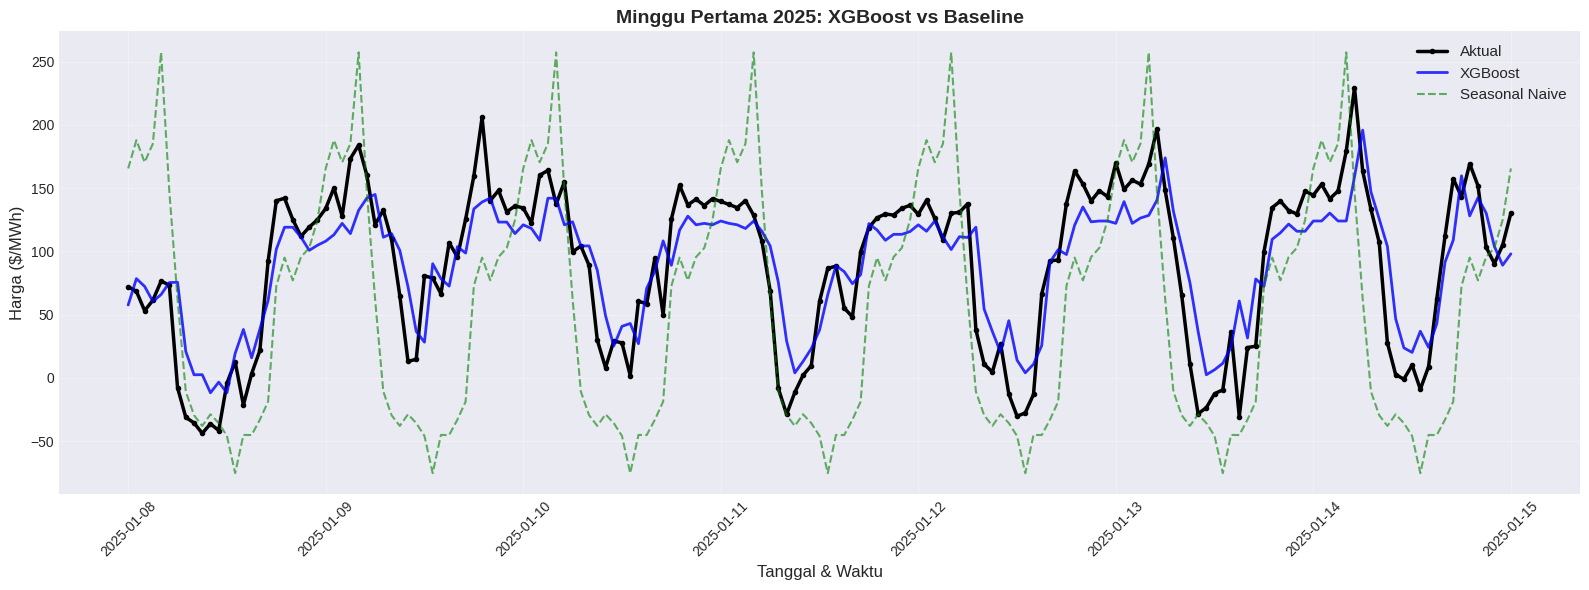


 Observasi:
   - XGBoost lebih adaptif terhadap perubahan
   - Tidak terlalu smooth seperti moving average
   - Lebih akurat menangkap variasi kecil


In [62]:
# Get first week index from test_clean
first_week_mask = test_clean['ds'] <= (test_clean['ds'].min() + pd.Timedelta(days=7))
first_week_data = test_clean[first_week_mask]

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(first_week_data['ds'], first_week_data['y'], 
        label='Aktual', color='black', linewidth=2.5, marker='o', markersize=3)
ax.plot(first_week_data['ds'], xgb_pred[first_week_mask], 
        label='XGBoost', color='blue', linewidth=2, alpha=0.8)
ax.plot(first_week_data['ds'], baseline_aligned[first_week_mask], 
        label='Seasonal Naive', color='green', linewidth=1.5, 
        linestyle='--', alpha=0.6)

ax.set_xlabel('Tanggal & Waktu', fontsize=12)
ax.set_ylabel('Harga ($/MWh)', fontsize=12)
ax.set_title('Minggu Pertama 2025: XGBoost vs Baseline', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n Observasi:")
print("   - XGBoost lebih adaptif terhadap perubahan")
print("   - Tidak terlalu smooth seperti moving average")
print("   - Lebih akurat menangkap variasi kecil")

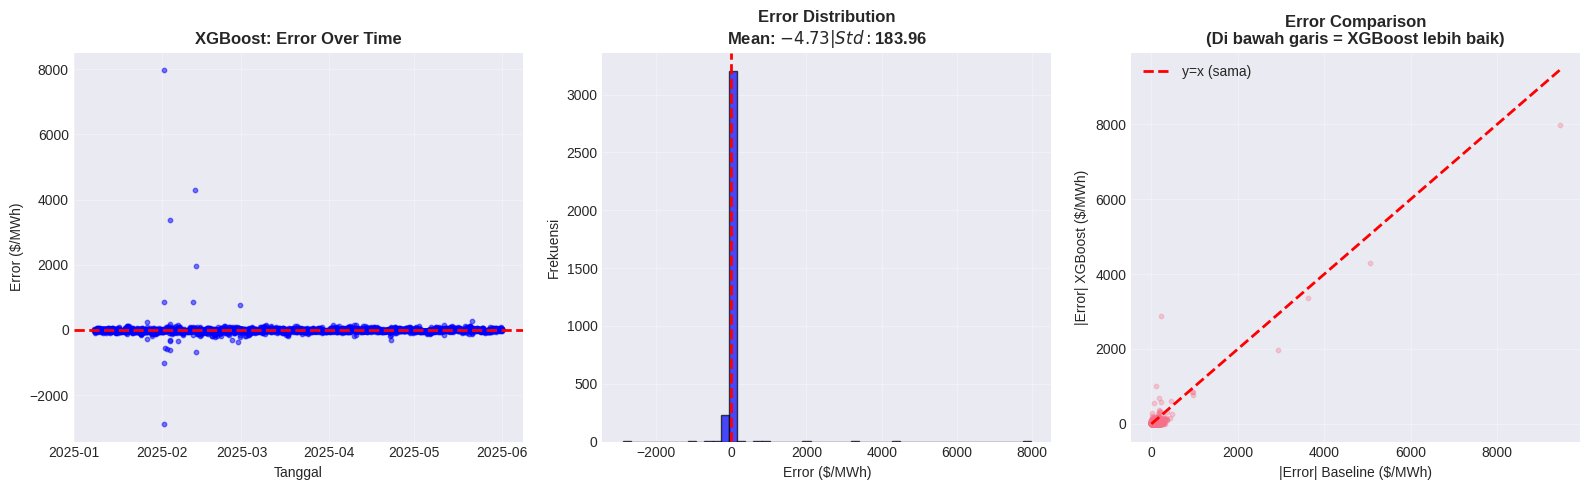


 Error Statistics:

XGBoost:
   Mean: $-4.73
   Std: $183.96
   95% dalam range: $87.96

Baseline:
   Mean: $20.32
   Std: $223.61
   95% dalam range: $201.66

Performa per-point:
   XGBoost lebih baik: 2,465 points (71.3%)
   Baseline lebih baik: 992 points (28.7%)


In [63]:
error_xgb = y_test.values - xgb_pred
error_baseline = y_test.values - baseline_aligned

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Error over time
axes[0].scatter(test_dates, error_xgb, alpha=0.5, s=10, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Tanggal')
axes[0].set_ylabel('Error ($/MWh)')
axes[0].set_title('XGBoost: Error Over Time', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Error distribution
axes[1].hist(error_xgb, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Error ($/MWh)')
axes[1].set_ylabel('Frekuensi')
axes[1].set_title(f'Error Distribution\nMean: ${np.mean(error_xgb):.2f} | Std: ${np.std(error_xgb):.2f}', 
                  fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Comparison: XGBoost vs Baseline
axes[2].scatter(np.abs(error_baseline), np.abs(error_xgb), alpha=0.3, s=10)
axes[2].plot([0, np.abs(error_baseline).max()], [0, np.abs(error_baseline).max()], 
             'r--', linewidth=2, label='y=x (sama)')
axes[2].set_xlabel('|Error| Baseline ($/MWh)')
axes[2].set_ylabel('|Error| XGBoost ($/MWh)')
axes[2].set_title('Error Comparison\n(Di bawah garis = XGBoost lebih baik)', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n Error Statistics:")
print(f"\nXGBoost:")
print(f"   Mean: ${np.mean(error_xgb):.2f}")
print(f"   Std: ${np.std(error_xgb):.2f}")
print(f"   95% dalam range: ${np.percentile(np.abs(error_xgb), 95):.2f}")

print(f"\nBaseline:")
print(f"   Mean: ${np.mean(error_baseline):.2f}")
print(f"   Std: ${np.std(error_baseline):.2f}")
print(f"   95% dalam range: ${np.percentile(np.abs(error_baseline), 95):.2f}")

# Count improvement
better_count = (np.abs(error_xgb) < np.abs(error_baseline)).sum()
worse_count = (np.abs(error_xgb) > np.abs(error_baseline)).sum()

print(f"\nPerforma per-point:")
print(f"   XGBoost lebih baik: {better_count:,} points ({better_count/len(error_xgb)*100:.1f}%)")
print(f"   Baseline lebih baik: {worse_count:,} points ({worse_count/len(error_xgb)*100:.1f}%)")

Analisis Price Spikes (> $165.77):
   Jumlah spike points: 346 (10.0%)

Performa pada SPIKE periods:
   XGBoost MAE: $131.59
   Baseline MAE: $209.47
   Improvement: +37.2%

Performa pada NORMAL periods:
   XGBoost MAE: $29.67
   Baseline MAE: $71.24
   Improvement: +58.3%


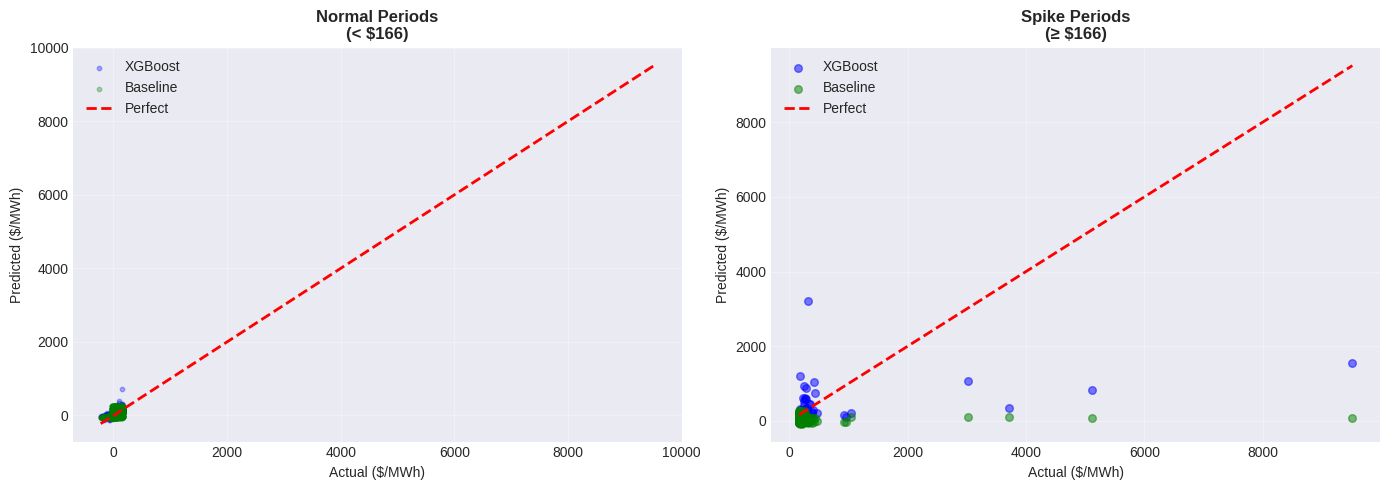

In [64]:
"""
Analisis: Performa pada extreme values
"""

# Identifikasi spikes (> 90th percentile)
spike_threshold = np.percentile(y_test, 90)
spike_mask = y_test > spike_threshold

print(f"Analisis Price Spikes (> ${spike_threshold:.2f}):")
print(f"   Jumlah spike points: {spike_mask.sum():,} ({spike_mask.sum()/len(y_test)*100:.1f}%)")

# MAE pada spikes vs normal
mae_xgb_spike = mean_absolute_error(y_test[spike_mask], xgb_pred[spike_mask])
mae_xgb_normal = mean_absolute_error(y_test[~spike_mask], xgb_pred[~spike_mask])

mae_baseline_spike = mean_absolute_error(y_test[spike_mask], baseline_aligned[spike_mask])
mae_baseline_normal = mean_absolute_error(y_test[~spike_mask], baseline_aligned[~spike_mask])

print(f"\nPerforma pada SPIKE periods:")
print(f"   XGBoost MAE: ${mae_xgb_spike:.2f}")
print(f"   Baseline MAE: ${mae_baseline_spike:.2f}")
print(f"   Improvement: {(1 - mae_xgb_spike/mae_baseline_spike)*100:+.1f}%")

print(f"\nPerforma pada NORMAL periods:")
print(f"   XGBoost MAE: ${mae_xgb_normal:.2f}")
print(f"   Baseline MAE: ${mae_baseline_normal:.2f}")
print(f"   Improvement: {(1 - mae_xgb_normal/mae_baseline_normal)*100:+.1f}%")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Normal periods
axes[0].scatter(y_test[~spike_mask], xgb_pred[~spike_mask], 
                alpha=0.3, s=10, color='blue', label='XGBoost')
axes[0].scatter(y_test[~spike_mask], baseline_aligned[~spike_mask], 
                alpha=0.3, s=10, color='green', label='Baseline')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect')
axes[0].set_xlabel('Actual ($/MWh)')
axes[0].set_ylabel('Predicted ($/MWh)')
axes[0].set_title(f'Normal Periods\n(< ${spike_threshold:.0f})', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spike periods
axes[1].scatter(y_test[spike_mask], xgb_pred[spike_mask], 
                alpha=0.5, s=30, color='blue', label='XGBoost')
axes[1].scatter(y_test[spike_mask], baseline_aligned[spike_mask], 
                alpha=0.5, s=30, color='green', label='Baseline')
axes[1].plot([y_test[spike_mask].min(), y_test[spike_mask].max()], 
             [y_test[spike_mask].min(), y_test[spike_mask].max()], 
             'r--', linewidth=2, label='Perfect')
axes[1].set_xlabel('Actual ($/MWh)')
axes[1].set_ylabel('Predicted ($/MWh)')
axes[1].set_title(f'Spike Periods\n(≥ ${spike_threshold:.0f})', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()